# The Bird Brains

## Imports

In [ ]:
# enable GPU runtime prior to running this cell
!nvidia-smi
import torch
print(torch.cuda.is_available())

Wed Mar  5 18:09:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import cudf
import cupy as cp
import numpy as np
import numba
from cuml.ensemble import RandomForestClassifier
from cuml.cluster import KMeans as cuKMeans
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

In [ ]:
import polars as pl
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/CSC 581 Project/weather_lookup_data.csv"
df = pl.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,TAXON CONCEPT ID,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,EXOTIC CODE,OBSERVATION COUNT,BREEDING CODE,BREEDING CATEGORY,BEHAVIOR CODE,AGE/SEX,COUNTRY,COUNTRY CODE,STATE,STATE CODE,COUNTY,COUNTY CODE,IBA CODE,BCR CODE,USFWS CODE,ATLAS BLOCK,LOCALITY,LOCALITY ID,LOCALITY TYPE,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,OBSERVER ID,SAMPLING EVENT IDENTIFIER,PROTOCOL TYPE,PROTOCOL CODE,PROJECT CODE,DURATION MINUTES,EFFORT DISTANCE KM,EFFORT AREA HA,NUMBER OBSERVERS,ALL SPECIES REPORTED,GROUP IDENTIFIER,HAS MEDIA,APPROVED,REVIEWED,REASON,TRIP COMMENTS,SPECIES COMMENTS,DATE_KEY,LOCATION_KEY,WEATHER_KEY,YEAR_MONTH,precipitation_probability,surface_pressure,wind_speed_180m,temperature_180m,hour_used
str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,f64,f64,str,f64,i64,str,i64,i64,i64,str,str,str,str,str,str,str,str,f64,f64,f64,i64
"""URN:CornellLabOfOrnithology:EB…","""2024-04-29 16:16:24.912765""",5973,"""species""","""avibase-9A684C99""","""Bar-tailed Godwit""","""Limosa lapponica""",null,null,null,"""6""",null,null,null,null,"""Australia""","""AU""","""Queensland""","""AU-QLD""","""Redland""","""AU-QLD-RED""","""BIRDLIFE_23545""",null,null,null,"""Nandeebie Park / Oyster Pt, Cl…","""L2559923""","""H""",-27.53152,153.28197,"""2023-10-16""","""10:00:00""","""obsr763219""","""S152949200""","""Traveling""","""P22""","""EBIRD""",20.0,0.5,null,2.0,1,null,0,1,0,null,null,"""Nandeebie Claypan - the first …","""2023-10-16""","""-27.53_153.28""","""2023-10-16_-27.53_153.28""","""2023-10""",null,1011.5927,7.927948,22.074001,12
"""URN:CornellLabOfOrnithology:EB…","""2024-03-02 18:24:29.211063""",5973,"""species""","""avibase-9A684C99""","""Bar-tailed Godwit""","""Limosa lapponica""",null,null,null,"""5""",null,null,null,null,"""Saudi Arabia""","""SA""","""Jizan""","""SA-09""",null,null,null,null,null,null,"""Jizan Heritage Village (القرية…","""L16302712""","""H""",16.827842,42.618395,"""2023-10-11""","""14:06:00""","""obsr130299""","""S152524724""","""Traveling""","""P22""","""EBIRD""",63.0,4.022,null,1.0,0,"""G11007816""",0,1,0,null,null,null,"""2023-10-11""","""16.83_42.62""","""2023-10-11_16.83_42.62""","""2023-10""",null,1006.48865,17.57149,31.265001,12
"""URN:CornellLabOfOrnithology:EB…","""2024-04-29 16:20:59.371313""",5973,"""species""","""avibase-9A684C99""","""Bar-tailed Godwit""","""Limosa lapponica""",null,null,null,"""X""",null,null,null,null,"""Australia""","""AU""","""Western Australia""","""AU-WA""","""Broome""","""AU-WA-BRM""",null,null,null,null,"""Wader Spit (Roebuck Bay)""","""L3442562""","""H""",-17.979327,122.336533,"""2023-10-31""","""09:24:00""","""obsr1612499""","""S153448912""","""Stationary""","""P21""","""EBIRD""",104.0,null,null,1.0,1,null,0,1,0,null,null,null,"""2023-10-31""","""-17.98_122.34""","""2023-10-31_-17.98_122.34""","""2023-10""",null,1011.79486,12.545163,25.5195,12
"""URN:CornellLabOfOrnithology:EB…","""2024-02-05 20:48:43.865971""",5973,"""species""","""avibase-9A684C99""","""Bar-tailed Godwit""","""Limosa lapponica""",null,null,null,"""2""",null,null,null,null,"""Hong Kong""","""HK""","""Hong Kong""","""HK-""",null,null,"""BIRDLIFE_16078""",null,null,null,"""Mai Po Nature Reserve""","""L1012793""","""H""",22.49418,114.036552,"""2023-10-11""","""08:45:00""","""obsr3560678""","""S151943496""","""Traveling""","""P22""","""EBIRD""",525.0,4.0,null,1.0,1,null,0,1,0,null,"""Partly cloudy, high tide at po…",null,"""2023-10-11""","""22.49_114.04""","""2023-10-11_22.49_114.04""","""2023-10""",null,1017.7669,12.545163,23.221,12
"""URN:CornellLabOfOrnithology:EB…","""2024-10-20 22:49:02.256708""",5973,"""species""","""avibase-9A684C99""","""Bar-tailed Godwit""","""Limosa lapponica""",null,null,null,"""1""",null,null,null,null,"""South Africa""","""ZA""","""Western Cape""","""ZA-WC""",null,null,"""B

In [ ]:
df["COUNTY"].null_count()

2209

In [ ]:
df["STATE"].null_count()

0

## Preprocessing

In [ ]:
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/CSC 581 Project/weather_lookup_data.csv"
df = cudf.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,TAXON CONCEPT ID,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,EXOTIC CODE,...,SPECIES COMMENTS,DATE_KEY,LOCATION_KEY,WEATHER_KEY,YEAR_MONTH,precipitation_probability,surface_pressure,wind_speed_180m,temperature_180m,hour_used
0,URN:CornellLabOfOrnithology:EBIRD:OBS1858517380,2024-04-29 16:16:24.912765,5973,species,avibase-9A684C99,Bar-tailed Godwit,Limosa lapponica,<NA>,<NA>,<NA>,...,Nandeebie Claypan - the first we have seen usi...,2023-10-16,-27.53_153.28,2023-10-16_-27.53_153.28,2023-10,<NA>,1011.59270,7.927948,22.074001,12
1,URN:CornellLabOfOrnithology:EBIRD:OBS1854071066,2024-03-02 18:24:29.211063,5973,species,avibase-9A684C99,Bar-tailed Godwit,Limosa lapponica,<NA>,<NA>,<NA>,...,<NA>,2023-10-11,16.83_42.62,2023-10-11_16.83_42.62,2023-10,<NA>,1006.48865,17.571490,31.265001,12
2,URN:CornellLabOfOrnithology:EBIRD:OBS1863810009,2024-04-29 16:20:59.371313,5973,species,avibase-9A684C99,Bar-tailed Godwit,Limosa lapponica,<NA>,<NA>,<NA>,...,<NA>,2023-10-31,-17.98_122.34,2023-10-31_-17.98_122.34,2023-10,<NA>,1011.79486,12.545163,25.519500,12
3,URN:CornellLabOfOrnithology:EBIRD:OBS1847614845,2024-02-05 20:48:43.865971,5973,species,avibase-9A684C99,Bar-tailed Godwit,Limosa lapponica,<NA>,<NA>,<NA>,...,<NA>,2023-10-11,22.49_114.04,2023-10-11_22.49_114.04,2023-10,<NA>,1017.76690,12.545163,23.221000,12
4,URN:CornellLabOfOrnithology:EBIRD:OBS1851205731,2024-10-20 22:49:02.256708,5973,species,avibase-9A684C99,Bar-tailed Godwit,Limosa lapponica,<NA>,<NA>,<NA>,...,<NA>,2023-10-09,-33.19_18.13,2023-10-09_-33.19_18.13,2023-10,<NA>,1015.58320,7.645174,20.496500,12


In [ ]:
df['OBSERVATION DATE'] = cudf.to_datetime(df['OBSERVATION DATE'], format='%Y-%m-%d')

# Extract YEAR, MONTH, and DAY OF YEAR
df['YEAR'] = df['OBSERVATION DATE'].dt.year
df['MONTH'] = df['OBSERVATION DATE'].dt.month
df['DAY OF YEAR'] = df['OBSERVATION DATE'].dt.day_of_year

## Filtering
Filtering for the year 2020-2024

In [ ]:
df["COUNTRY"].value_counts()
df["YEAR"].value_counts()

YEAR
2024    3819
2023    3491
2022    2668
Name: count, dtype: int64

In [ ]:
df = df[(df['YEAR'] >= 2020) & (df['YEAR'] <= 2024)]
df = df[df['OBSERVATION COUNT'].str.contains('X') == False]
df['OBSERVATION COUNT'] = df['OBSERVATION COUNT'].astype('int32')
df = df[df['COUNTRY'].isin(['United Kingdom', 'Australia', 'New Zealand'])]
len(df)

3820

In [ ]:
df['SEASON'] = 0  # Initialize column

df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 1  # Winter
df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 2  # Spring
df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 3  # Summer
df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 4  # Fall
df.head()

df_pd = df.to_pandas()

seasons = df_pd['SEASON'].unique()

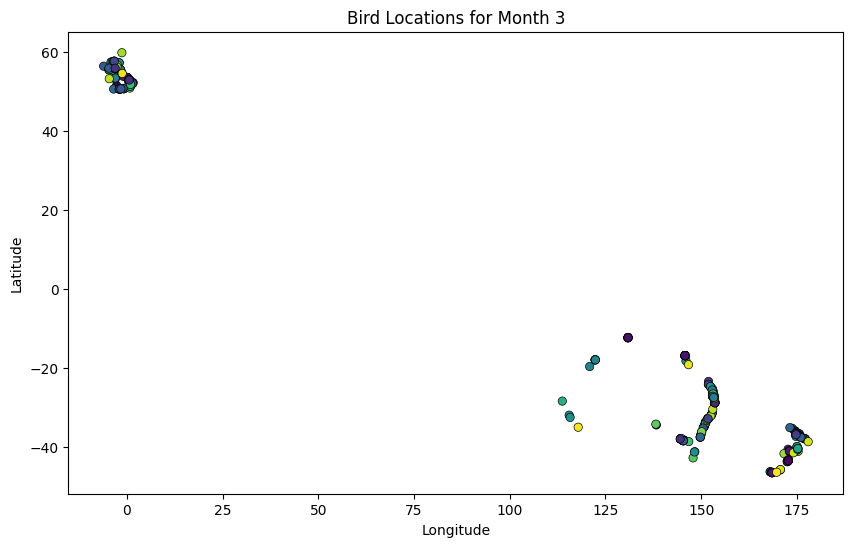

In [ ]:
def filter_by_month(month):

    # Filter data for the specific month
    month_data = df[df['MONTH'] == month]

    # Convert the filtered data to pandas for plotting
    month_data_pd = month_data.to_pandas()

    # Plotting the data for the selected month
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=month_data_pd['LONGITUDE'],
        y=month_data_pd['LATITUDE'],
        hue=month_data_pd['COUNTY'],
        palette='viridis',
        edgecolor='black',
        legend=False
    )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Bird Locations for Month {month}")
    plt.show()

filter_by_month(3) #(1 to 12)

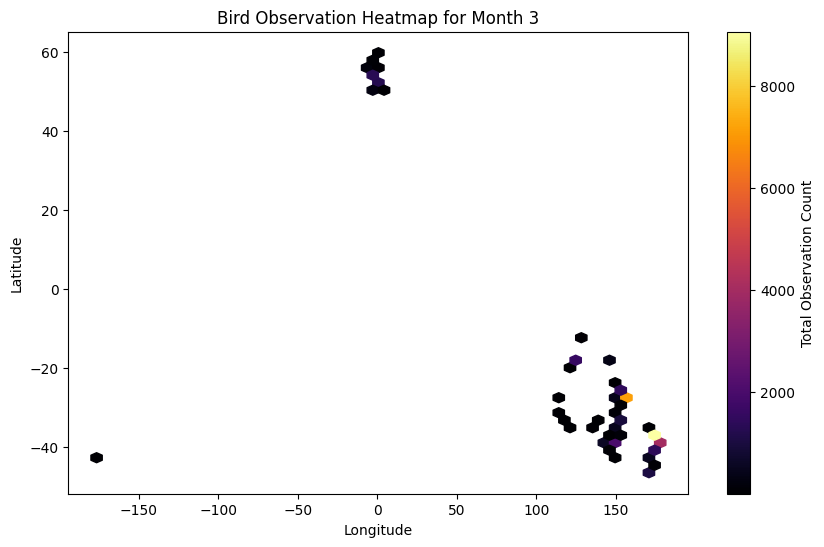

In [ ]:


def filter_by_month_heatmap(month):
    # Filter data for the specific month and day
    month_data = df[(df['MONTH'] == month)]

    # Convert to pandas for plotting
    month_data_pd = month_data.to_pandas()

    # Create heatmap using hexbin
    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(
        month_data_pd['LONGITUDE'],
        month_data_pd['LATITUDE'],
        C=month_data_pd['OBSERVATION COUNT'],
        gridsize=50,  # Adjust for resolution
        cmap='inferno',
        reduce_C_function=np.sum
    )

    plt.colorbar(hb, label='Total Observation Count')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Bird Observation Heatmap for Month {month}")
    plt.show()

# Example: Generate heatmap for March (3)
filter_by_month_heatmap(3)

## Training

In [ ]:
df["county_encoded"] = df["COUNTY"].factorize()[0]
df["state_encoded"] = df["STATE"].factorize()[0]

In [ ]:
df.columns.to_list()

['GLOBAL UNIQUE IDENTIFIER',
 'LAST EDITED DATE',
 'TAXONOMIC ORDER',
 'CATEGORY',
 'TAXON CONCEPT ID',
 'COMMON NAME',
 'SCIENTIFIC NAME',
 'SUBSPECIES COMMON NAME',
 'SUBSPECIES SCIENTIFIC NAME',
 'EXOTIC CODE',
 'OBSERVATION COUNT',
 'BREEDING CODE',
 'BREEDING CATEGORY',
 'BEHAVIOR CODE',
 'AGE/SEX',
 'COUNTRY',
 'COUNTRY CODE',
 'STATE',
 'STATE CODE',
 'COUNTY',
 'COUNTY CODE',
 'IBA CODE',
 'BCR CODE',
 'USFWS CODE',
 'ATLAS BLOCK',
 'LOCALITY',
 'LOCALITY ID',
 'LOCALITY TYPE',
 'LATITUDE',
 'LONGITUDE',
 'OBSERVATION DATE',
 'TIME OBSERVATIONS STARTED',
 'OBSERVER ID',
 'SAMPLING EVENT IDENTIFIER',
 'PROTOCOL TYPE',
 'PROTOCOL CODE',
 'PROJECT CODE',
 'DURATION MINUTES',
 'EFFORT DISTANCE KM',
 'EFFORT AREA HA',
 'NUMBER OBSERVERS',
 'ALL SPECIES REPORTED',
 'GROUP IDENTIFIER',
 'HAS MEDIA',
 'APPROVED',
 'REVIEWED',
 'REASON',
 'TRIP COMMENTS',
 'SPECIES COMMENTS',
 'DATE_KEY',
 'LOCATION_KEY',
 'WEATHER_KEY',
 'YEAR_MONTH',
 'precipitation_probability',
 'surface_pressure',


In [ ]:
nan_counts = df[["DAY OF YEAR", "YEAR", "SEASON", "LATITUDE", "LONGITUDE",
                 "county_encoded", "state_encoded", "precipitation_probability",
                 "surface_pressure", "wind_speed_180m", "temperature_180m"]].isna().sum()

# Convert to a cuDF DataFrame
nan_counts_df = cudf.DataFrame({"Column": nan_counts.index, "NaN Count": nan_counts.values})

print(nan_counts_df)
df.shape


                       Column  NaN Count
0                 DAY OF YEAR          0
1                        YEAR          0
2                      SEASON          0
3                    LATITUDE          0
4                   LONGITUDE          0
5              county_encoded          0
6               state_encoded          0
7   precipitation_probability       7676
8            surface_pressure          0
9             wind_speed_180m          0
10           temperature_180m          0


(7687, 64)

In [ ]:
# df = df.dropna(subset=["DAY OF YEAR", "YEAR", "SEASON", "LATITUDE", "LONGITUDE",
#                         "county_encoded", "state_encoded", "precipitation_probability",
#                         "surface_pressure", "wind_speed_180m", "temperature_180m"])
df = df.dropna(subset=["DAY OF YEAR", "YEAR", "SEASON", "LATITUDE", "LONGITUDE",
                        "county_encoded", "state_encoded",
                        "surface_pressure", "wind_speed_180m", "temperature_180m"])

X = df[["DAY OF YEAR", "YEAR", "SEASON", "LATITUDE", "LONGITUDE",
        "county_encoded", "state_encoded",
        "surface_pressure", "wind_speed_180m", "temperature_180m"]]
y = df["OBSERVATION COUNT"]

bins = [0, 10, 100, cp.inf]
labels = [0, 1, 2]  # 0=low, 1=medium, 2=high
df["density_class"] = cudf.cut(y, bins=bins, labels=labels).astype("int32")
y = df["density_class"]

In [ ]:
X.shape

(3820, 10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.to_pandas())
X_test_scaled = scaler.transform(X_test.to_pandas())

In [ ]:
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).cuda()
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).cuda()
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long).cuda()
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long).cuda()

In [ ]:
y_train_torch

tensor([0, 1, 0,  ..., 0, 0, 1], device='cuda:0')

In [ ]:
class BirdNN(nn.Module):
    def __init__(self):
        super(BirdNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 density classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
# Train Neural Network
print("Training Neural Network with CUDA...")
model = BirdNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Neural Network with CUDA...


In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.0860
Epoch 2, Loss: 1.0758
Epoch 3, Loss: 1.0658
Epoch 4, Loss: 1.0559
Epoch 5, Loss: 1.0460
Epoch 6, Loss: 1.0364
Epoch 7, Loss: 1.0268
Epoch 8, Loss: 1.0175
Epoch 9, Loss: 1.0084
Epoch 10, Loss: 0.9996
Epoch 11, Loss: 0.9912
Epoch 12, Loss: 0.9832
Epoch 13, Loss: 0.9758
Epoch 14, Loss: 0.9689
Epoch 15, Loss: 0.9626
Epoch 16, Loss: 0.9569
Epoch 17, Loss: 0.9519
Epoch 18, Loss: 0.9476
Epoch 19, Loss: 0.9439
Epoch 20, Loss: 0.9408
Epoch 21, Loss: 0.9382
Epoch 22, Loss: 0.9361
Epoch 23, Loss: 0.9344
Epoch 24, Loss: 0.9331
Epoch 25, Loss: 0.9319
Epoch 26, Loss: 0.9310
Epoch 27, Loss: 0.9302
Epoch 28, Loss: 0.9295
Epoch 29, Loss: 0.9287
Epoch 30, Loss: 0.9280
Epoch 31, Loss: 0.9271
Epoch 32, Loss: 0.9261
Epoch 33, Loss: 0.9250
Epoch 34, Loss: 0.9238
Epoch 35, Loss: 0.9225
Epoch 36, Loss: 0.9213
Epoch 37, Loss: 0.9200
Epoch 38, Loss: 0.9188
Epoch 39, Loss: 0.9176
Epoch 40, Loss: 0.9165
Epoch 41, Loss: 0.9155
Epoch 42, Loss: 0.9145
Epoch 43, Loss: 0.9136
Epoch 44, Loss: 0.91

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_torch).float().mean().item()
    print("Neural Network Accuracy:", accuracy)

Neural Network Accuracy: 0.5405759215354919


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Adjust architecture
class ImprovedBirdNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedBirdNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # More neurons
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)  # Output layer (3 classes)
        self.dropout = nn.Dropout(0.3)  # Dropout to reduce overfitting

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  # Logits for CrossEntropyLoss

# Calculate class weights for imbalanced data
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0,1,2]), y=y.to_pandas())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda()

# Model training setup
model = ImprovedBirdNN(X_train.shape[1]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Use weighted loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)  # Reduce LR every 100 epochs

# Train with early stopping
best_accuracy = 0
patience = 10
trigger = 0

for epoch in range(500):  # More epochs, but with early stopping
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_torch).float().mean().item()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"Final Accuracy: {best_accuracy:.4f}")


Epoch 1, Loss: 1.1256, Accuracy: 0.4764
Epoch 2, Loss: 1.1099, Accuracy: 0.3848
Epoch 3, Loss: 1.0960, Accuracy: 0.3547
Epoch 4, Loss: 1.0912, Accuracy: 0.3325
Epoch 5, Loss: 1.0871, Accuracy: 0.3652
Epoch 6, Loss: 1.0816, Accuracy: 0.4110
Epoch 7, Loss: 1.0780, Accuracy: 0.4241
Epoch 8, Loss: 1.0716, Accuracy: 0.4293
Epoch 9, Loss: 1.0694, Accuracy: 0.4476
Epoch 10, Loss: 1.0679, Accuracy: 0.4634
Epoch 11, Loss: 1.0585, Accuracy: 0.4725
Early stopping at epoch 11
Final Accuracy: 0.4764


Decision Tree Accuracy: 0.5615
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       449
           1       0.37      0.31      0.34       219
           2       0.32      0.20      0.25        96

    accuracy                           0.56       764
   macro avg       0.45      0.42      0.43       764
weighted avg       0.53      0.56      0.54       764



<ipython-input-38-1e5060320222>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='viridis')


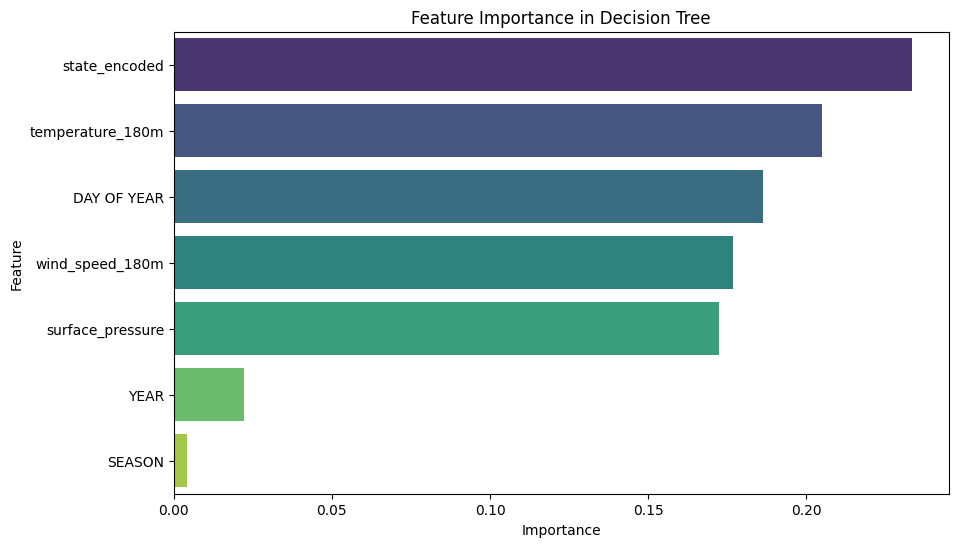

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert to Pandas for compatibility
X_train_pd = X_train.to_pandas()
X_test_pd = X_test.to_pandas()
y_train_pd = y_train.to_pandas()
y_test_pd = y_test.to_pandas()

# Initialize Decision Tree Classifier
tree_model = DecisionTreeClassifier(
    criterion="gini",       # Use 'entropy' for information gain
    max_depth=10,           # Control depth to prevent overfitting
    min_samples_split=5,    # Minimum samples needed to split
    min_samples_leaf=3,     # Minimum samples per leaf
    random_state=42
)

# Train model
tree_model.fit(X_train_pd, y_train_pd)

# Make predictions
y_pred = tree_model.predict(X_test_pd)

# Evaluate accuracy
accuracy = accuracy_score(y_test_pd, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Classification Report
print(classification_report(y_test_pd, y_pred))

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()


In [ ]:
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pd, y_train_pd)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.5749334103526845


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Convert to numpy
X_train_np = X_train.to_pandas().values
X_test_np = X_test.to_pandas().values
y_train_np = y_train.to_pandas().values
y_test_np = y_test.to_pandas().values

# Reshape to (samples, timesteps, features) for RNN
seq_length = 20  # Use last 5 time steps to predict
num_features = X_train_np.shape[1]

def create_sequences(data_X, data_y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i+seq_length])
        y_seq.append(data_y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_np, y_train_np, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_np, y_test_np, seq_length)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train_seq, dtype=torch.float32).cuda()
X_test_torch = torch.tensor(X_test_seq, dtype=torch.float32).cuda()
y_train_torch = torch.tensor(y_train_seq, dtype=torch.long).cuda()
y_test_torch = torch.tensor(y_test_seq, dtype=torch.long).cuda()

print(f"RNN Input Shape: {X_train_torch.shape}")  # Expected: (num_samples, seq_length, num_features)


RNN Input Shape: torch.Size([3036, 20, 7])


In [ ]:
class BirdRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BirdRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = num_features
hidden_size = 64
num_layers = 2
num_classes = 3

# Initialize model
model = BirdRNN(input_size, hidden_size, num_layers, num_classes).cuda()


In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    loss.backward()
    optimizer.step()

    # Print loss every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training Complete!")


Epoch [5/1000], Loss: 1.0159
Epoch [10/1000], Loss: 0.9529
Epoch [15/1000], Loss: 0.9403
Epoch [20/1000], Loss: 0.9440
Epoch [25/1000], Loss: 0.9394
Epoch [30/1000], Loss: 0.9375
Epoch [35/1000], Loss: 0.9381
Epoch [40/1000], Loss: 0.9381
Epoch [45/1000], Loss: 0.9377
Epoch [50/1000], Loss: 0.9375
Epoch [55/1000], Loss: 0.9375
Epoch [60/1000], Loss: 0.9375
Epoch [65/1000], Loss: 0.9375
Epoch [70/1000], Loss: 0.9375
Epoch [75/1000], Loss: 0.9375
Epoch [80/1000], Loss: 0.9375
Epoch [85/1000], Loss: 0.9374
Epoch [90/1000], Loss: 0.9374
Epoch [95/1000], Loss: 0.9374
Epoch [100/1000], Loss: 0.9374
Epoch [105/1000], Loss: 0.9374
Epoch [110/1000], Loss: 0.9374
Epoch [115/1000], Loss: 0.9374
Epoch [120/1000], Loss: 0.9374
Epoch [125/1000], Loss: 0.9374
Epoch [130/1000], Loss: 0.9374
Epoch [135/1000], Loss: 0.9374
Epoch [140/1000], Loss: 0.9374
Epoch [145/1000], Loss: 0.9374
Epoch [150/1000], Loss: 0.9374
Epoch [155/1000], Loss: 0.9374
Epoch [160/1000], Loss: 0.9374
Epoch [165/1000], Loss: 0.93

In [ ]:
# Evaluation mode
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_torch).float().mean().item()

print(f"RNN Test Accuracy: {accuracy:.4f}")


RNN Test Accuracy: 0.5255


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

historical_date = {"DAY OF YEAR": 74, "YEAR": 2023}  # March 15

# Filter for relevant locations
historical_data = df[(df["DAY OF YEAR"] == historical_date["DAY OF YEAR"]) & (df["YEAR"] == historical_date["YEAR"])]

if historical_data.empty:
    print("No historical data available for this date.")
else:
    # Prepare input features
    X_historical = historical_data[["DAY OF YEAR", "YEAR", "LATITUDE", "LONGITUDE", "county_encoded", "state_encoded"]]

    # Scale the features
    X_historical_scaled = scaler.transform(X_historical.to_pandas())

    # Convert to CUDA tensors
    X_historical_torch = torch.tensor(X_historical_scaled, dtype=torch.float32).cuda()

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_historical_torch)
        _, predicted_classes = torch.max(predictions, 1)

    historical_data["Predicted Density"] = predicted_classes.cpu().numpy()

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=historical_data["LONGITUDE"].to_pandas(),
        y=historical_data["LATITUDE"].to_pandas(),
        hue=historical_data["Predicted Density"].to_pandas(),
        palette="coolwarm",
        edgecolor="black"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Predicted Bird Density on {historical_date['YEAR']}-03-15")
    plt.legend(title="Density (0=Low, 1=Medium, 2=High)")
    plt.show()


No historical data available for this date.
